In [1]:
# Do not reload
import sys, os
sys.path.append("../")
os.chdir('../')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.config import DATA_PATH, MODELS_PATH
from src.common import input_keys, agg_trns, pickle_model_obj, unpickle_model_obj
from src.preprocess import Preprocessor
from src.model import ForestWrapper

%load_ext autoreload
%autoreload 2

In [3]:
df = pd.read_csv(DATA_PATH / 'generated_ad_data.csv.gz', sep=';', compression='gzip', parse_dates=[input_keys.TIME_KEY])
df.head()

,REQUEST_TIME,DEVICE_IP,DEVICE_IFA,GEO_CURRENT_CITY,DEVICE_LANGUAGE,GENERATED_AS_BOT
0,2022-12-21 00:50:53.675734,181.160.87.69,336a7994-5681-4bf4-aedd-094a9f66fc8b,Tel Aviv,en,0
1,2022-12-21 08:12:54.768470,181.160.87.69,336a7994-5681-4bf4-aedd-094a9f66fc8b,Tel Aviv,en,0
2,2022-12-21 09:23:27.587814,246.251.252.84,336a7994-5681-4bf4-aedd-094a9f66fc8b,Tel Aviv,en,0
3,2022-12-21 10:10:07.653369,246.251.252.84,336a7994-5681-4bf4-aedd-094a9f66fc8b,Tel Aviv,en,0
4,2022-12-21 11:00:28.802860,181.160.87.69,336a7994-5681-4bf4-aedd-094a9f66fc8b,Tel Aviv,en,0


In [4]:
preprocessor = Preprocessor(input_keys, agg_trns)
final_df = preprocessor.fit_transform(df)

pickle_model_obj(preprocessor, 'preprocessor.pkl')
    
final_df['BOT'] = df.groupby(input_keys.PRIMARY_KEY)['GENERATED_AS_BOT'].agg(min).values

D:\Data\Data Science\Interviews\Intelos\sleep-detector\sleep-detector\src\preprocess.py:101: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_feats.drop(columns=self.input_keys.PRIMARY_KEY)


After feature engineering:

In [5]:
final_df.head()

,DEVICE_IFA,0,1,2,3,4,5,6,7,8,...,CUMNORM_21,CUMNORM_22,"(TIME_DIFF, mean)","(TIME_DIFF, max)","(TIME_DIFF, min)","(TIME_DIFF, std)","(DEVICE_IP, nunique)","(GEO_CURRENT_CITY, nunique)","(DEVICE_LANGUAGE, nunique)",BOT
0,00025785-d2fc-4eba-b0b6-20161bb384a1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,...,1.000000,1.000000,1454.425321,15878.924343,36.334221,2654.773304,3,1,1,0
1,0013a26e-18bb-407b-9843-d21d11715001,37.0,8.0,8.0,8.0,5.0,5.0,3.0,2.0,3.0,...,0.820051,0.853470,222.617578,2180.140969,0.060273,323.247393,2,1,1,1
2,0036a4bd-3c39-4f54-b835-88a69082cac6,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.673469,0.775510,1754.756594,37112.774977,14.916581,5368.956182,2,1,1,0
3,0042b0d1-bc4e-45f4-b2d2-c374b1a71d4e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,...,0.966102,0.983051,959.642526,5779.182410,16.502620,1261.264601,1,1,1,0
4,0069ae1b-e702-4ce4-9c42-be80aec2b142,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.977778,1.000000,1819.481828,39952.280912,0.717315,5982.626922,1,1,1,0


# Visualizations

The average hourly activity profiles are different for bots and humans:

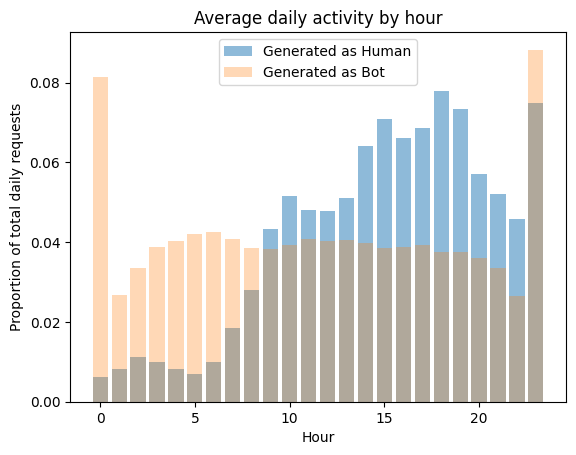

In [6]:
norm_df = final_df[[f'NORM_{i}' for i in range(24)]]

plt.title('Average daily activity by hour')
plt.bar(range(24), norm_df[final_df['BOT']==0].mean(axis=0), alpha=0.5, label='Generated as Human')
plt.bar(range(24), norm_df[final_df['BOT']==1].mean(axis=0), alpha=0.3, label='Generated as Bot')
plt.ylabel('Proportion of total daily requests')
plt.xlabel('Hour')
plt.legend()
plt.show()

Bots:
- have much less number of hours with zero activity;
- can have large total number of requests daily;
- have less average time difference between consecutive requests;
- have less variance (std) in the time difference between consecutive requests.

Illustrations:

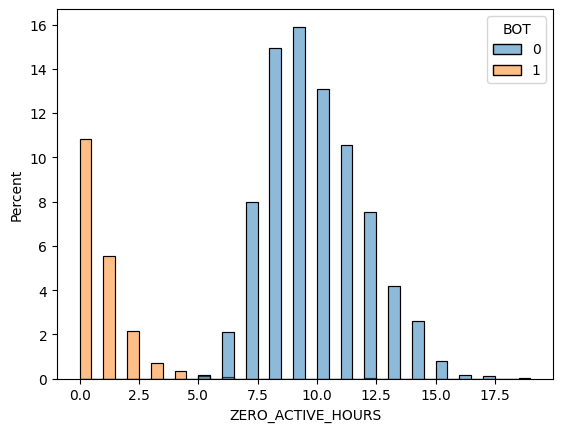

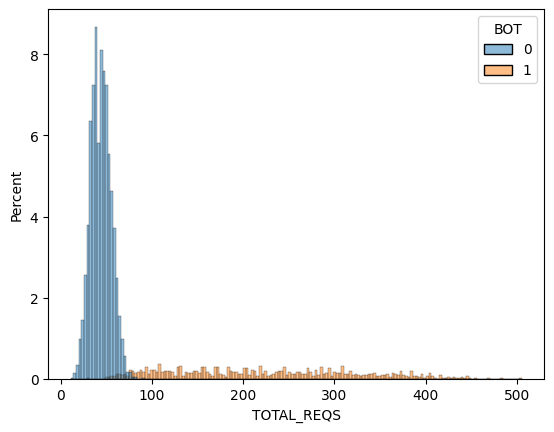

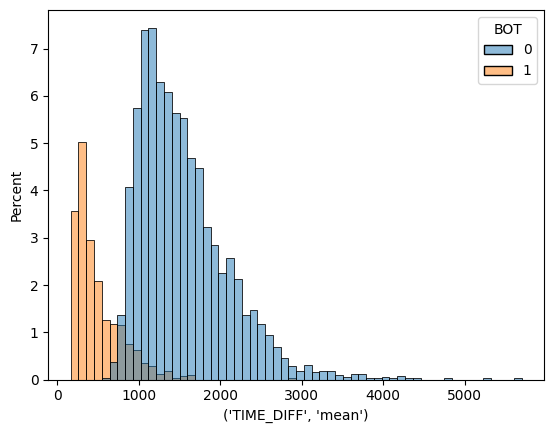

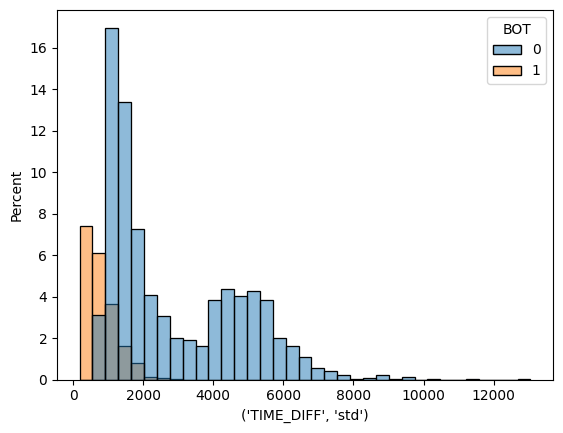

In [7]:
features = ['ZERO_ACTIVE_HOURS', 'TOTAL_REQS', ('TIME_DIFF', 'mean'), ('TIME_DIFF', 'std')]
for col in features:
    sns.histplot(x=final_df[col], hue=final_df['BOT'], stat='percent')
    plt.show()

Graphs provided above show that features produced can indeed be used to identify abnormal sleeping activity.

# Modelling

In [8]:
clf = ForestWrapper(n_estimators=300, contamination=0.2)
train_preds = clf.fit_predict(final_df.drop(columns=[input_keys.PRIMARY_KEY, 'BOT']))

pickle_model_obj(clf, 'forest.pkl')

C:\Users\Vlad\Miniconda3\envs\sleepdetect\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Vlad\Miniconda3\envs\sleepdetect\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


In [9]:
print('Overall accuracy on train part:', ((train_preds < 0) == final_df['BOT']).mean())
print('Recall on train part:', (train_preds[final_df['BOT'] == 1] < 0).mean())
print('Precision on train part:', final_df[train_preds < 0]['BOT'].mean())

Overall accuracy on train part: 0.9260474507824331
Recall on train part: 0.8188775510204082
Precision on train part: 0.8095838587641866


# Checking on test data (generated by the same process):

In [10]:
test_df = pd.read_csv(
    DATA_PATH / 'generated_ad_data_test.csv.gz', sep=';', compression='gzip', parse_dates=[input_keys.TIME_KEY]
)
test_df.head()

,REQUEST_TIME,DEVICE_IP,DEVICE_IFA,GEO_CURRENT_CITY,DEVICE_LANGUAGE,GENERATED_AS_BOT
0,2022-12-20 07:00:40.277293,217.118.235.206,448f022e-e846-4c6b-a3fe-703ccd387461,Petah Tiqwa,he,0
1,2022-12-20 07:19:23.972710,222.122.182.246,448f022e-e846-4c6b-a3fe-703ccd387461,Petah Tiqwa,he,0
2,2022-12-20 07:40:53.039525,217.118.235.206,448f022e-e846-4c6b-a3fe-703ccd387461,Petah Tiqwa,he,0
3,2022-12-20 07:09:51.517634,217.118.235.206,448f022e-e846-4c6b-a3fe-703ccd387461,Petah Tiqwa,he,0
4,2022-12-20 08:54:07.957772,222.122.182.246,448f022e-e846-4c6b-a3fe-703ccd387461,Petah Tiqwa,he,0


In [11]:
preprocessor = unpickle_model_obj('preprocessor.pkl')
clf = unpickle_model_obj('forest.pkl')


final_test_df = preprocessor.transform(test_df)
final_test_df['BOT'] = test_df.groupby(input_keys.PRIMARY_KEY)['GENERATED_AS_BOT'].agg(min).values

D:\Data\Data Science\Interviews\Intelos\sleep-detector\sleep-detector\src\preprocess.py:101: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_feats.drop(columns=self.input_keys.PRIMARY_KEY)


In [12]:
test_preds = clf.predict(final_test_df.drop(columns=[input_keys.PRIMARY_KEY, 'BOT']))

C:\Users\Vlad\Miniconda3\envs\sleepdetect\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


In [13]:
print('Overall accuracy on test part:', ((test_preds < 0) == final_test_df['BOT']).mean())
print('Recall on test part:', (test_preds[final_test_df['BOT'] == 1] < 0).mean())
print('Precision on test part:', final_test_df[test_preds < 0]['BOT'].mean())

Overall accuracy on test part: 0.9401197604790419
Recall on test part: 0.8526315789473684
Precision on test part: 0.8350515463917526


# Visualize test performance

In [14]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans

In [15]:
tsne = TSNE(n_components=2, perplexity=35)
data_2d = tsne.fit_transform(final_test_df.drop(columns=[input_keys.PRIMARY_KEY]))

C:\Users\Vlad\Miniconda3\envs\sleepdetect\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Vlad\Miniconda3\envs\sleepdetect\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Vlad\Miniconda3\envs\sleepdetect\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


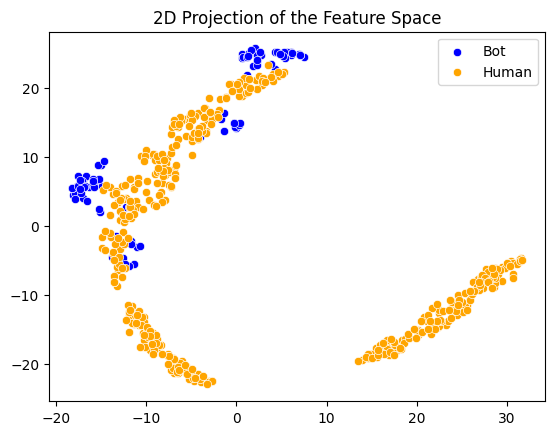

In [16]:
plt.title('2D Projection of the Feature Space')
sns.scatterplot(
    x=data_2d[final_test_df['BOT'] == 1][:, 0], y=data_2d[final_test_df['BOT'] == 1][:, 1], color='blue', label='Bot'
)
sns.scatterplot(
    x=data_2d[final_test_df['BOT'] == 0][:, 0], y=data_2d[final_test_df['BOT'] == 0][:, 1], color='orange', label='Human'
)
plt.legend()
plt.show()

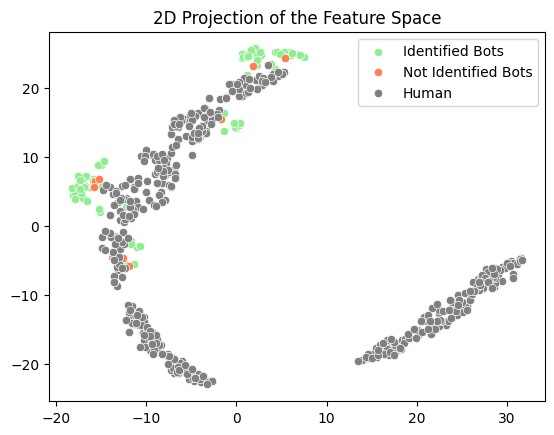

In [17]:
plt.title('2D Projection of the Feature Space')
sns.scatterplot(
    x=data_2d[(final_test_df['BOT'] == 1) & (test_preds < 0)][:, 0], y=data_2d[(final_test_df['BOT'] == 1) & (test_preds < 0)][:, 1], 
    color='lightgreen', label='Identified Bots')
sns.scatterplot(
    x=data_2d[(final_test_df['BOT'] == 1) & (test_preds >= 0)][:, 0], y=data_2d[(final_test_df['BOT'] == 1) & (test_preds >= 0)][:, 1], 
    color='coral', label='Not Identified Bots')
sns.scatterplot(
    x=data_2d[final_test_df['BOT'] == 0][:, 0], y=data_2d[final_test_df['BOT'] == 0][:, 1], color='grey', label='Human'
)

plt.legend()
plt.show()